# グラフ彩色問題

グラフ $G=(V,E)$ の頂点集合の分割 $V_1, \ldots, V_K$ でそれぞれの部分集合 $V_i \subset V$ が安定集合のとき，この分割を $G$ の $K$ 彩色と呼ぶ．

**グラフ彩色問題**: $G$ に対して $K$ 彩色が存在する最小の $K$ を求めよ．

## 標準定式化

\begin{align*}
\mathrm{minimize\ } &\sum_{k=1}^{K_\mathrm{max}} y_k \\
\mathrm{subject\ to\ } &\sum_{k=1}^{K_\mathrm{max}} x_{ik} = 1 \quad \forall i \in V \\
&x_{ik} + x_{jk} \le y_{k} \quad \forall (i,j) \in E, \ \forall k = 1,2,\ldots,K_\mathrm{max} \\
&x_{ik} \in \{0, 1\} \quad \forall i \in V, \ \forall k = 1,2,\ldots,K_\mathrm{max} \\
&y_k \in \{0, 1\} \quad \forall k = 1,2,\ldots,K_\mathrm{max}
\end{align*}


さらに，色クラスの対称性は分枝限定法の性能を悪化させるので，添え字の小さい色ラベルを優先して1にするよう制約を追加すると良いらしい．

\begin{align*}
& y_k \le \sum_{i \in V} x_{ik} \quad \forall k = 1,2,\ldots, K_\mathrm{max} \\
& y_k \ge y_{k+1} \quad \forall k=1,2,\ldots, K_\mathrm{max} - 1
\end{align*}

二つ目の制約は対称性というより，目的関数の性質から自然に0になるべき変数を明示的に0にするような制約？


In [1]:
import random
import networkx as nx
from pyscipopt import Model, quicksum
import matplotlib.pyplot as plt


random.seed(123)
n = 10
K = n
pos = {i: (random.random(), random.random()) for i in range(n)}
G = nx.random_geometric_graph(n, 0.5, pos=pos)

V = G.nodes()
E = G.edges()

model = Model("gcp - standard")
x, y = {}, {}
for i in V:

    for k in range(K):
        x[i, k] = model.addVar(vtype="B", name=f"x({i},{k})")
for k in range(K):
    y[k] = model.addVar(vtype="B", name=f"y({k})")
# model.update()

for i in V:
    model.addCons(quicksum(x[i, k] for k in range(K)) == 1, f"AssignColor({i})")

for (i, j) in E:
    for k in range(K):
        model.addCons(x[i, k] + x[j, k] <= y[k], f"BadEdge({i},{j},{k})")
for k in range(K):
    model.addCons(y[k] <= quicksum(x[i, k] for i in V), f"SymmetryBreak1({k})")

for k in range(K - 1):
    model.addCons(y[k] >= y[k + 1], f"SymmetryBreak2({k})")

model.setObjective(quicksum(y[k] for k in range(K)), sense='minimize')

model.optimize()


presolving:
(round 1, exhaustive) 0 del vars, 0 del conss, 0 add conss, 0 chg bounds, 0 chg sides, 0 chg coeffs, 379 upgd conss, 0 impls, 369 clqs
   (0.0s) probing: 60/110 (54.5%) - 2 fixings, 0 aggregations, 312 implications, 0 bound changes
   (0.0s) probing aborted: 50/50 successive totally useless probings
(round 2, exhaustive) 2 del vars, 0 del conss, 0 add conss, 0 chg bounds, 0 chg sides, 0 chg coeffs, 379 upgd conss, 0 impls, 668 clqs
(round 3, fast)       2 del vars, 2 del conss, 0 add conss, 0 chg bounds, 0 chg sides, 2 chg coeffs, 379 upgd conss, 0 impls, 668 clqs
(round 4, exhaustive) 2 del vars, 22 del conss, 2 add conss, 0 chg bounds, 0 chg sides, 2 chg coeffs, 379 upgd conss, 0 impls, 668 clqs
   (0.0s) probing: 65/110 (59.1%) - 2 fixings, 0 aggregations, 312 implications, 0 bound changes
   (0.0s) probing aborted: 50/50 successive totally useless probings
   (0.0s) symmetry computation started: requiring (bin +, int +, cont +), (fixed: bin -, int -, cont -)
   (0.0s) s

solution: {0: 2, 1: 0, 2: 4, 3: 2, 4: 5, 5: 4, 6: 5, 7: 1, 8: 3, 9: 6}


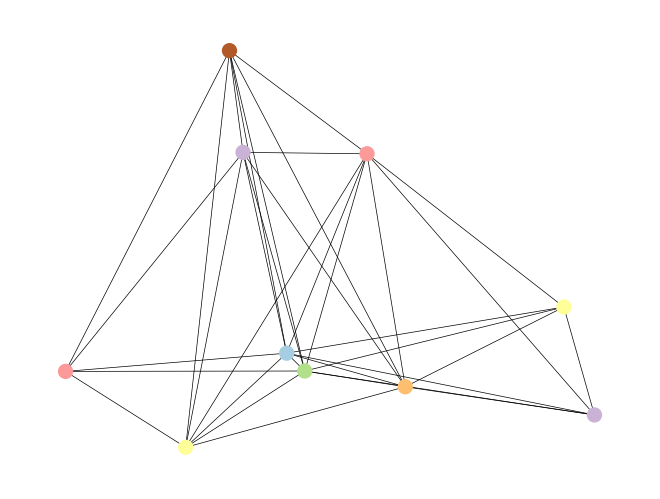

In [ ]:
color = {}
if model.getStatus() == 'optimal':
    best_sol = model.getBestSol()
    for i in V:
        for k in range(K):
            if best_sol[x[i, k]] > 0.5:
                color[i] = k
                break

print("solution:", color)

nx.draw(
    G,
    pos=pos,
    with_labels=False,
    node_color=[color[i] for i in V],
    node_size=100,
    cmap=plt.cm.Paired,
    edge_color="black",
    width=0.5,
)

順序制約を付加せずに解いてみる

In [11]:
model = Model("gcp - naive")
x, y = {}, {}
for i in V:

    for k in range(K):
        x[i, k] = model.addVar(vtype="B", name=f"x({i},{k})")
for k in range(K):
    y[k] = model.addVar(vtype="B", name=f"y({k})")
# model.update()

for i in V:
    model.addCons(quicksum(x[i, k] for k in range(K)) == 1, f"AssignColor({i})")

for (i, j) in E:
    for k in range(K):
        model.addCons(x[i, k] + x[j, k] <= y[k], f"BadEdge({i},{j},{k})")
# for k in range(K):
#     model.addCons(y[k] <= quicksum(x[i, k] for i in V), f"SymmetryBreak1({k})")

# for k in range(K - 1):
#     model.addCons(y[k] >= y[k + 1], f"SymmetryBreak2({k})")

model.setObjective(quicksum(y[k] for k in range(K)), sense='minimize')

model.optimize()


presolving:
(round 1, exhaustive) 0 del vars, 0 del conss, 0 add conss, 0 chg bounds, 0 chg sides, 0 chg coeffs, 360 upgd conss, 0 impls, 360 clqs
   (0.0s) probing: 51/110 (46.4%) - 0 fixings, 0 aggregations, 0 implications, 0 bound changes
   (0.0s) probing aborted: 50/50 successive totally useless probings
   (0.0s) symmetry computation started: requiring (bin +, int +, cont +), (fixed: bin -, int -, cont -)
   (0.0s) symmetry computation finished: 14 generators found (max: 1500, log10 of symmetry group size: 0.0) (symcode time: 0.00)
dynamic symmetry handling statistics:
   orbitopal reduction:       no components
   orbital reduction:          1 components of sizes 14
   lexicographic reduction:   14 permutations with support sizes 20, 20, 20, 20, 20, 22, 22, 22, 22, 22, 22, 22, 22, 22
handled 1 out of 1 symmetry components
presolving (2 rounds: 2 fast, 2 medium, 2 exhaustive):
 0 deleted vars, 0 deleted constraints, 0 added constraints, 0 tightened bounds, 0 added holes, 0 change

## 彩色数固定定式化

$K$ を固定して実行可能解を探索し，$K$ に関する二分探索によって最小の色数を求める．

$K$ を固定したときの実行可能解(=彩色)は以下の最適化問題の最適解として得られる．

\begin{align*}
\mathrm{minimize\ } &\sum_{(i,j) \in E} z_{ij} \\
\mathrm{subject\ to\ } &\sum_{k=1}^{K} x_{ik} = 1 \quad \forall i \in V \\
&x_{ik} + x_{jk} \le 1 + z_{ij} \quad \forall (i,j) \in E, \ \forall k = 1,2,\ldots,K \\
&x_{ik} \in \{0, 1\} \quad \forall i \in V, \ \forall k = 1,2,\ldots,K \\
&z_{ij} \in \{0, 1\} \quad \forall k = 1,2,\ldots,K_\mathrm{max}
\end{align*}

Q. 変数の数は辺の数だけ増えるので結構大きくなるが解きにくくはならないのか？


In [18]:
def gcp_fixed_k(V, E, K):
    """gcp_fixed_k -- model for minimizing number
    of bad edges in coloring a graph
    Parameters:
        - V: set/list of nodes in the graph
        - E: set/list of edges in the graph
        - K: number of colors to be used
    Returns a model, ready to be solved.
    """
    model = Model("gcp - fixed k")
    x, z = {}, {}
    for i in V:
        for k in range(K):
            x[i, k] = model.addVar(vtype="B", name=f"x({i},{k})")
    for (i, j) in E:
        z[i, j] = model.addVar(vtype="B", name=f"z({i},{j})")
    # model.update()

    for i in V:
        model.addCons(quicksum(x[i, k] for k in range(K)) == 1, f"AssignColor({i})")

    for (i, j) in E:
        for k in range(K):
            model.addCons(x[i, k] + x[j, k] <= 1 + z[i, j], f"BadEdge({i},{j},{k})")

    model.setObjective(quicksum(z[i, j] for (i, j) in E), sense='minimize')

    #model.update()
    #model.__data = x, z
    return model, x

In [23]:
def solve_gcp(V, E):
    """solve_gcp -- solve the graph coloring problem
    with bisection and fixed-k model
    Parameters:
        - V: set/list of nodes in the graph
        - E: set/list of edges in the graph
    Returns tuple with number of colors used,
    and dictionary mapping colors to vertices
    """
    LB = 0
    UB = len(V)
    color = {}
    while UB - LB > 1:
        K = (UB + LB) // 2
        print("trying fixed K=", K)
        gcp, x = gcp_fixed_k(V, E, K)
        #gcp.Params.OutputFlag = 0  # silent mode
        gcp.hideOutput()
        # Cutoff 以上の目的関数値しか許さない
        #gcp.Params.Cutoff = 0.1
        gcp.setObjlimit(0.1)
        gcp.optimize()
        if gcp.getStatus() == 'optimal':
            best_sol = model.getBestSol()
            for i in V:
                for k in range(K):
                    if best_sol[x[i, k]] > 0.5:
                        color[i] = k
                        break
                # else:
                #     raise "undefined color for", i
            UB = K
        else:
            LB = K

    return UB, color

In [24]:
K, color = solve_gcp(V, E)
print("minimum number of colors:", K)
print("solution:", color)

trying fixed K= 5
trying fixed K= 7
trying fixed K= 6
minimum number of colors: 7
solution: {0: 0, 1: 1, 2: 2, 3: 0, 4: 3, 5: 2, 6: 3, 7: 4, 8: 5, 9: 6}


AMPL による求解

In [25]:
from amplpy import AMPL

ampl = AMPL()
ampl.option['solver'] = 'highs'
ampl.read("../ampl/gcp_fixed_k.mod")
ampl.set['V'] = list(V)
ampl.set['E'] = list(E)

LB = 0
UB = len(V)
while UB - LB > 1:
    K = (UB + LB) // 2
    print("current K:{}\t[LB:{},UB:{}]".format(K,LB,UB))
    ampl.param['K'] = K
    ampl.solve()
    Z = ampl.obj['Z']
    #print("Bad edges:", Z.value())

    if Z.value() > .5:
        LB = K
        z = ampl.var['z']
#         for (i, j) in E:
#             if z[i, j].value() > .5:
#                 print("Bad edge:", (i, j))
    else:
        UB = K
        x = ampl.var['x']
        for k in range(1, K + 1):
            vk = [i for i in V if x[i, k].value() > .5]
            #print("color {} used in {}".format(k, vk))

print()
print("Chromatic number:", UB)
print("color {} used in {}".format(k, vk))

*******************************************************************************
*                                                                             *
* Please make sure that the AMPL directory is in the system search path, or   *
* add it before instantiating the AMPL object with:                           *
*                                                                             *
*     from amplpy import AMPL, add_to_path                                    *
*     add_to_path(r"full path to the AMPL installation directory")            *
*     ampl = AMPL()                                                           *
*                                                                             *
* Or, if you are using amplpy.modules, please make sure that they are installed: *
*                                                                             *
*     # Install solver modules (e.g., HiGHS, CBC, Gurobi)                     *
*     $ python -m amplpy.modules inst

RuntimeError: AMPL could not be started. Message from process thread:
cannot execute ampl: No such file or directory



## 半順序定式化

色の間に順序関係をつけて解の対称性を除去して定式化する

以下の補助変数を導入する．
- $y_{ik}$: 頂点 $i$ の色が $k$ よりも大きいとき1，そうでなければ0
- $z_{ik}$: 頂点 $i$ の色が $k$ よりも小さいとき1，そうでなければ0

さらに，グラフの頂点 $0\in V$ を一つ固定して，その色が「最も大きい」色となるようにする

\begin{align}
\mathrm{minimize\ } &1 + \sum_{k=1}^{K_\mathrm{max}} y_{0k} \\
\mathrm{subject\ to\ } &x_{ik} = 1- (y_{ik} + z_{ik}) \quad \forall i \in V \ \forall k = 1,2,\ldots,K_\mathrm{max} \\
& z_{i1} = 0 \quad \forall i \in V \\
& y_{iK_\mathrm{max}} = 0 \quad \forall i \in V \\
& y_{ik} \ge y_{i,k+1} \quad \forall i \in V \ \forall k=1,2,\ldots, K_\mathrm{max} - 1 \\
& y_{ik} + z_{i,k+1} = 1 \quad \forall i \in V \ \forall k=1,2,\ldots, K_\mathrm{max} - 1 \\
& y_{0k} \ge y_{ik} \quad \forall i \in V \setminus \{0\} \ \forall k=1,2,\ldots, K_\mathrm{max} - 1 \\
&x_{ik} + x_{jk} \le 1 \quad \forall (i,j) \in E, \ \forall k = 1,2,\ldots,K_\mathrm{max} \\
&x_{ik} \in \{0, 1\} \quad \forall i \in V, \ \forall k = 1,2,\ldots,K_\mathrm{max} \\
&y_{ik} \in \{0, 1\} \quad \forall i \in V, \ \forall k = 1,2,\ldots,K_\mathrm{max} \\
&z_{ik} \in \{0, 1\} \quad \forall i \in V, \ \forall k = 1,2,\ldots,K_\mathrm{max} \\
\end{align}



定式化の構造
- 各頂点 $i$ に対して $(y_{ik}, z_{ik})$ の値は $k$ の小さい順に途中まで (1,0), 途中で一回だけ (0,0), そのあとは (0,1) となる
    - (0,0) になる $k$ が色ラベルに対応する: 制約 (2)
    - 制約 (3) (4) (5) (6) によってこの構造が定まっている
- 制約 (7) で特別な頂点 $0\in V$ で最大の色ラベルを取得して目的関数 (1) に使う
- 制約 (8) はもともとの彩色の条件

In [30]:
K = n
model = Model("gcp - partial order")
x, y, z = {}, {}, {}
for i in V:
    for k in range(K):
        x[i, k] = model.addVar(vtype="B", name=f"x({i},{k})")
        y[k, i] = model.addVar(vtype="B", name=f"y({k},{i})")
        z[i, k] = model.addVar(vtype="B", name=f"z({i},{k})")
#model.update()

for i in V:
    model.addCons(z[i, 0] == 0, f"FixZ({i})")
    model.addCons(y[K - 1, i] == 0, f"FixY({i})")

for i in V:
    for k in range(K - 1):
        model.addCons(y[k, i] >= y[k + 1, i], f"Ordering({i},{k})")
        model.addCons(y[k, i] + z[i, k + 1] == 1, f"AssignColor({i},{k})")
        model.addCons(y[k, 0] >= y[k, i], f"FirstNode({i},{k})")

# for i in V:
#    model.addCons(quicksum(x[i,k] for k in range(K)) == 1,
#                    f"AssignColor({i})")

for i in V:
    for k in range(K):
        model.addCons(x[i, k] == 1 - (y[k, i] + z[i, k]), f"Connection({i},{k})")

for (i, j) in E:
    for k in range(K):
        model.addCons(x[i, k] + x[j, k] <= 1, f"BadEdge({i},{j},{k})")

model.setObjective(1 + quicksum(y[k, 0] for k in range(K)), 'minimize')

model.optimize()

presolving:
(round 1, fast)       130 del vars, 149 del conss, 0 add conss, 20 chg bounds, 0 chg sides, 0 chg coeffs, 0 upgd conss, 0 impls, 591 clqs
(round 2, medium)     133 del vars, 149 del conss, 0 add conss, 20 chg bounds, 0 chg sides, 0 chg coeffs, 0 upgd conss, 0 impls, 557 clqs
(round 3, fast)       136 del vars, 186 del conss, 0 add conss, 20 chg bounds, 0 chg sides, 0 chg coeffs, 0 upgd conss, 0 impls, 554 clqs
(round 4, exhaustive) 136 del vars, 263 del conss, 0 add conss, 20 chg bounds, 77 chg sides, 0 chg coeffs, 0 upgd conss, 0 impls, 554 clqs
(round 5, exhaustive) 136 del vars, 263 del conss, 0 add conss, 20 chg bounds, 77 chg sides, 0 chg coeffs, 477 upgd conss, 0 impls, 554 clqs
   (0.0s) probing cycle finished: starting next cycle
(round 6, exhaustive) 143 del vars, 263 del conss, 0 add conss, 20 chg bounds, 77 chg sides, 0 chg coeffs, 477 upgd conss, 0 impls, 1379 clqs
(round 7, fast)       144 del vars, 298 del conss, 0 add conss, 20 chg bounds, 77 chg sides, 0 chg

In [31]:
for i in V:
    for k in range(K):
        if model.getVal(x[i, k]) > 0.5:
            color[i] = k
            break

print("solution:", color)

solution: {0: 6, 1: 5, 2: 1, 3: 3, 4: 2, 5: 1, 6: 2, 7: 4, 8: 6, 9: 0}


## 代表点定式化

色ラベルと頂点を適当に同一視した定式化

**隣接しない**頂点 $i,j$ に対して決定変数 $x_{ij}$ を以下のように定める．

- $x_{ij}$: 
    - $i=j$ のとき，頂点 $i$ を色 $i$ で塗るなら1，それ以外の色なら0
    - $i\ne j$ のとき，頂点 $j$ を頂点 $i$ と同じ色で塗るなら1，そうでなければ0
        - $(i,j)$ に対して対称ではなさそう？

**イメージ**
- 自明な塗り分け 1->1, 2->2, 3->3, 4->4, 5->5 (色->頂点)からスタート
- いくつかの頂点は他の色 (他の頂点の色) で塗って良い
- 1->1, 1->2, 4->3, 4->4, 4->5 と塗れたら答えは2色

**定式化**

\begin{align}
\mathrm{minimize\ } &\sum_{i\in V} x_{ii} \\
\mathrm{subject\ to\ } &\sum_{i \in N_j \cup \{j\}} x_{ij} \ge 1 \quad \forall j \in V \\
&x_{ij} + x_{ik} \le x_{ii} \quad \forall i \in V, \ \forall (j,k) \in A_i \\
&x_{ij} \le x_{ii} \quad \forall i \in V, \ \forall j \in N_i \\
&x_{ik} \in \{0, 1\} \quad \forall i,j \in V
\end{align}

- $N_i$: 頂点 $j\in V$ に隣接**しない**頂点
- $A_i$: 頂点 $j\in V$ に隣接**しない**辺

- 制約 (2) は各点が代表点($x_{ii}=1$)か他の点の色に割り当てられることを表す
- 制約 (3) は $i$ が代表点でなければ($x_{ii}=0$)他の頂点は $i$ を参照しない(iとjが同じ代表点を持つことはありえる)，$i$ が代表点なら $i$ と隣接しない隣接2頂点のうち高々一つだけが $i$ と同じ色
- 制約 (4) は，他の点から参照されたら代表点でなければならないことを表す
    - 孤立点でなければ制約 (3) から従う？

Q. グラフ彩色問題を表現するためにこの制約で必要十分なことはどのように示す？

- 制約 (3) (4) は頂点 $i$ に隣接しない極大クリークで強化できるとのこと．(3)の左辺をクリークの上での和に置き換えれば良いか？

In [36]:
Gbar = nx.complement(G)

model = Model("gcp - representative")
x = {}
for i in V:
    for j in V:
        x[i, j] = model.addVar(vtype="B", name=f"x({i},{j})")
# model.update()

for j in V:
    model.addCons(
        quicksum(x[i, j] for i in Gbar.neighbors(j)) + x[j, j] >= 1, f"Assign({j})"
    )

for i in V:
    for (j, k) in G.subgraph(Gbar.neighbors(i)).edges():
        model.addCons(x[i, j] + x[i, k] <= x[i, i], f"BadEdge({i},{j},{k})")
    for j in Gbar.neighbors(i):
        model.addCons(x[i, j] <= x[i, i], f"Connection({i},{j})")

model.setObjective(quicksum(x[i, i] for i in V), 'minimize')
model.optimize()

feasible solution found by trivial heuristic after 0.0 seconds, objective value 1.000000e+01
presolving:
(round 1, fast)       76 del vars, 6 del conss, 0 add conss, 2 chg bounds, 0 chg sides, 0 chg coeffs, 0 upgd conss, 0 impls, 39 clqs
(round 2, exhaustive) 76 del vars, 25 del conss, 0 add conss, 2 chg bounds, 19 chg sides, 0 chg coeffs, 0 upgd conss, 0 impls, 39 clqs
(round 3, fast)       78 del vars, 25 del conss, 0 add conss, 2 chg bounds, 19 chg sides, 0 chg coeffs, 0 upgd conss, 0 impls, 31 clqs
(round 4, exhaustive) 78 del vars, 26 del conss, 0 add conss, 2 chg bounds, 20 chg sides, 0 chg coeffs, 0 upgd conss, 0 impls, 31 clqs
(round 5, exhaustive) 78 del vars, 26 del conss, 0 add conss, 2 chg bounds, 20 chg sides, 0 chg coeffs, 23 upgd conss, 0 impls, 31 clqs
(round 6, exhaustive) 78 del vars, 31 del conss, 0 add conss, 2 chg bounds, 20 chg sides, 0 chg coeffs, 23 upgd conss, 0 impls, 31 clqs
(round 7, exhaustive) 78 del vars, 31 del conss, 0 add conss, 2 chg bounds, 20 chg si

In [37]:
color = {}
k = 0
for i in V:
    if model.getVal(x[i, i]) > 0.5:
        color[i] = k
        k += 1

for (i, j) in x:
    if i != j and model.getVal(x[i, j]) > 0.5:
        color[j] = color[i]

print("solution:", color)

solution: {0: 2, 1: 1, 3: 2, 5: 3, 6: 4, 7: 5, 9: 6, 8: 0, 2: 4, 4: 6}
